In [71]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from mofapy2.run.entry_point import entry_point
from sklearn.preprocessing import StandardScaler

In [72]:
# CARICAMENTO DEL DATASET

file_path = r".\archive\All_Players_1992-2025.csv"
file_path:Path = Path(file_path)

original_df = pd.read_csv(file_path, encoding='utf-8')

print(f"Dimensioni originali del dataset: {original_df.shape}")
#print("Esempio formato stagione:", df_original['Season'].unique()[:5])

original_df = original_df[original_df['Season'] >= "2017-2018"].copy()

# verifica
print("-" * 30)
print(f"Dimensioni dopo il filtro: {original_df.shape}")
print("Stagioni rimaste:", sorted(original_df['Season'].unique()))

# Visualizziamo le prime righe
original_df.head()

Dimensioni originali del dataset: (92170, 120)
------------------------------
Dimensioni dopo il filtro: (27040, 120)
Stagioni rimaste: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']


,PlayerID,Player,Squad,League,Nation,Pos,Age,Born,Season,MP,...,The Best FIFA Mens Player,UEFA Best Player,UCL_MP,UCL_Gls,UCL_xG,UCL_Ast,UCL_xA,UCL_KP,UCL_GCA,UCL_SCA
5504,1681,Claudio Pizarro,Köln,Bundesliga,PER,"FW,MF",38.0,1978.0,2017-2018,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5513,1681,Claudio Pizarro,Werder Bremen,Bundesliga,PER,FW,39.0,1978.0,2018-2019,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5514,1681,Claudio Pizarro,Werder Bremen,Bundesliga,PER,"FW,MF",40.0,1978.0,2019-2020,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6280,1842,Roman Weidenfeller,Dortmund,Bundesliga,GER,GK,36.0,1980.0,2017-2018,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6465,1877,Alexander Meier,Eint Frankfurt,Bundesliga,GER,FW,34.0,1983.0,2017-2018,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# genero un ID univoco per ciascuna squadra in ciascuna stagione
original_df['SampleID'] = original_df['Squad'] + '_' + original_df['Season']

# considero solo la prima riga di ciascun raggruppamento. Le altre righe hanno gli stessi valori per le colonne selezionate
new_df = original_df.groupby(['SampleID'])[['Squad', 'Season', 'League', 'Nation']].first()
#print(new_df.head())

# calcolo nuova colonna: % di cross che portano a un tiro
original_df['CrsPA%'] = original_df['CrsPA'] / original_df['Crs'] * 100

sum_cols = [
    # Shooting / Scoring
    "Sh", "SoT", "Gls", "Ast", "PK", "PKatt", "PKcon", "OG",
    # Passing / Possesso
    "Cmp", "PassLive", "PassDead", "KP", "Crs", "CrsPA", "PPA", "Live", "Dead", "FK", "TB", "Sw", "TI", "CK", "Compl", "Mis",
    # Defensive Actions
    "Tkl", "TklW", "Tkld", "Int", "Blocks", "Clr", "Fls", "Recov",
    # Defensive Coverage
    "Def 3rd", "Mid 3rd", "Att 3rd", "Att Pen", "Off", "Dis",
    # Duels
    "Won", "Lost",
    # Chance creation / Progressive play
    "SCA", "PrgC", "PrgDist", "PrgP", "PrgR", "Rec", "Carries", "CPA",
    "Touches", "Dist", "TotDist"
]
wmean_cols = ['Age']

sums_df = original_df.groupby(['SampleID'])[sum_cols].sum()

# calcolo la media di alcune statistiche, pesata sul numero di minuti giocati dal giocatore per quella stagione
# moltiplica elemento per elemento la prima colonna per i minuti giocati dal giocatore
weighted_stats = original_df[wmean_cols].multiply(original_df['Min'], axis=0)
weighted_stats['SampleID'] = original_df['SampleID']

weighted_sums = weighted_stats.groupby(['SampleID'])[wmean_cols].sum()

# sommma i minuti di gioco per squadra e stagione
total_minutes = original_df.groupby(['SampleID'])['Min'].sum()

means_df = weighted_sums.divide(total_minutes, axis=0)

final_df = pd.concat([sums_df, means_df], axis=1)
print("Shape: ", final_df.shape)
final_df.head()

Shape:  (780, 52)


,Sh,SoT,Gls,Ast,PK,PKatt,PKcon,OG,Cmp,PassLive,...,PrgDist,PrgP,PrgR,Rec,Carries,CPA,Touches,Dist,TotDist,Age
SampleID,,,,,,,,,,,,,,,,,,,,,
Ajaccio_2022-2023,85.0,81.0,22.0,12.0,6.0,9.0,10.0,2.0,11216.0,350.0,...,81586.0,1169.0,1150.0,11114.0,12563.0,92.0,19271.0,540.7,206467.0,28.725482
Alavés_2017-2018,133.0,134.0,40.0,31.0,1.0,3.0,10.0,2.0,9696.0,439.0,...,81720.0,1045.0,1030.0,9603.0,9107.0,118.0,17988.0,521.0,182999.0,24.969426
Alavés_2018-2019,117.0,116.0,39.0,27.0,2.0,3.0,6.0,2.0,9631.0,458.0,...,84436.0,1113.0,1102.0,9540.0,8348.0,103.0,18475.0,394.4,186037.0,26.257689
Alavés_2019-2020,114.0,98.0,34.0,20.0,6.0,6.0,15.0,0.0,9612.0,333.0,...,82570.0,944.0,936.0,9525.0,9373.0,100.0,17865.0,417.0,182169.0,27.002590
Alavés_2020-2021,90.0,95.0,35.0,21.0,5.0,8.0,3.0,0.0,10217.0,375.0,...,86617.0,939.0,926.0,10113.0,8984.0,104.0,18196.0,388.5,196749.0,28.193105


In [74]:
# Standardizzazione dei dati.
# Permette di ricondurre una distribuzione a una distribuzione con media 0 e deviazione standard 1.
# normalizzazione Z-score: (x - mean) / stddev

scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)
final_df_norm = pd.DataFrame(scaled_data, index=final_df.index, columns=final_df.columns)

print("Prima della normalizzazione:")
print(final_df.iloc[:, 0].head(3)) # Esempio colonna con valori alti

print("\nDopo la normalizzazione (Z-scores):")
print(final_df_norm.iloc[:, 0].head(3))

Prima della normalizzazione:
SampleID
Ajaccio_2022-2023     85.0
Alavés_2017-2018     133.0
Alavés_2018-2019     117.0
Name: Sh, dtype: float64

Dopo la normalizzazione (Z-scores):
SampleID
Ajaccio_2022-2023   -1.088788
Alavés_2017-2018     0.615188
Alavés_2018-2019     0.047196
Name: Sh, dtype: float64


In [ ]:
# definisco le viste
views_definition = {
    'Attack': [
        "Sh", "SoT", "Gls", "Ast", "PK", "PKatt", "PKcon","SCA", "PrgC", "PrgDist", "PrgP", "PrgR", "Rec", "Carries", "CPA"
    ],
    'Possession': [
        "Cmp", "PassLive", "PassDead", "KP", "Crs", "CrsPA", "PPA", "Live", "Dead", "FK", "TB", "Sw", "TI", "CK", "Compl", "Mis", "Touches", "Dist", "TotDist"
    ],
    'Defense':[
        "Tkl", "TklW", "Tkld", "Int", "Blocks", "Clr", "Fls", "Recov", "Def 3rd", "Mid 3rd", "Att 3rd", "Att Pen", "Off", "Dis", "Won", "Lost", "OG"
    ],
    'Demographics': ["Age"]
}

data_for_mofa = [] # Lista di matrici
view_names = []    # Lista dei nomi delle viste

print("Creazione matrici per MOFA...")
for view_name, cols in views_definition.items():

    # Estraiamo la matrice di dati
    matrix = final_df_norm[cols].values
    
    # MOFA vuole le dimensioni (N_samples, N_features)
    print(f"Vista '{view_name}': {matrix.shape[1]} features trovate.")
    
    data_for_mofa.append([matrix])
    view_names.append(view_name)

Creazione matrici per MOFA...
Vista 'Attack': 15 features trovate.
Vista 'Possession': 19 features trovate.
Vista 'Defense': 17 features trovate.
Vista 'Demographics': 1 features trovate.


In [76]:
# ESECUZIONE DI MOFA 

if len(data_for_mofa) > 0:    

    # Inizializzazione
    ent = entry_point()
    
    # Data Options
    # Passiamo la lista di matrici. 
    # Importante: scale_views=True aiuta a bilanciare se l'Attacco ha numeri piccoli e il Possesso numeri grandi.
    ent.set_data_matrix(
        data=data_for_mofa, 
        likelihoods=['gaussian', 'gaussian', 'gaussian', 'gaussian'],
        views_names=view_names
    )
    ent.set_data_options(scale_views=True, center_groups=True)
    
    # Model Options
    # num_factors: Quanti "super-valori" vuoi trovare?
    ent.set_model_options(factors=15) # rimossi spikeslab_weights=True, ard_factors=True
    
    # Training Options
    # max_iter: numero di cicli di apprendimento
    ent.set_train_options(iter=1000, convergence_mode='slow', verbose=False)
    ent.build()
    
    # 5. RUN
    ent.run()
    ent.save(r".\model\mofa_model.hdf5", save_data=True)
    
    print("Training completato con successo!")
    
    # Salviamo il modello in un oggetto per usarlo dopo
    model = ent.model
else:
    print("Errore: Non ci sono dati validi per avviare il modello.")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='Attack' group='group0' with N=780 sa

Tipo restituito: <class 'list'>
Numero di viste trovate: 4
Varianza totale spiegata per vista:
 Attack          0.791301
Possession      0.659347
Defense         0.530480
Demographics    0.046120
dtype: float64


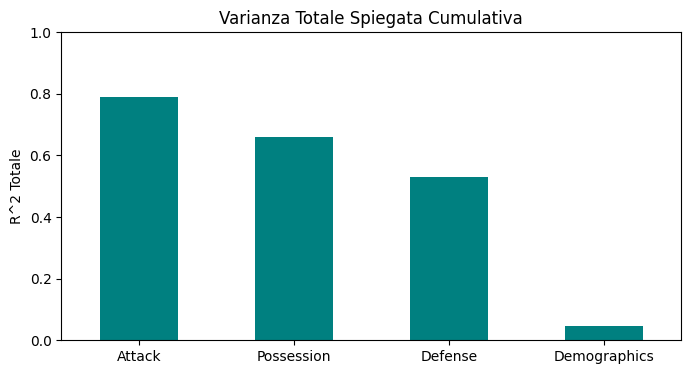

In [83]:
# 1. Calcola la varianza (che ritorna una lista)
r2_list = model.calculate_variance_explained()

# Verifica rapida
print(f"Tipo restituito: {type(r2_list)}")
print(f"Numero di viste trovate: {len(r2_list[0])}")

r2_data = dict()
for i, view_name in enumerate(view_names):
    r2_data[view_name] = r2_list[0][i]

r2_df = pd.DataFrame(r2_data).T
r2_df.columns = [f"LF {i+1}" for i in range(r2_df.shape[1])]

r2_total = r2_df.sum(axis=1)
print("Varianza totale spiegata per vista:\n", r2_total)

plt.figure(figsize=(8, 4))
r2_total.plot(kind='bar', color='teal')
plt.title("Varianza Totale Spiegata Cumulativa")
plt.ylabel("R^2 Totale")
plt.ylim(0, 1) # O il massimo teorico se superiore
plt.xticks(rotation=0, ha='center')
plt.show()

In [78]:
# VISUALIZZA FATTORI LATENTI (matrice Z)

# 1. Estraiamo il dizionario dei Fattori Latenti (Z)
z_dict = ent.model.getExpectations()["Z"]

# Stampiamo le chiavi per vedere come MOFA ha chiamato il gruppo
print(f"Nomi dei gruppi trovati nel modello: {list(z_dict.keys())}")

# Invece di scrivere [0], prendiamo dinamicamente la prima chiave disponibile
group_name = list(z_dict.keys())[0] 
Z_matrix = z_dict[group_name]

print(f"Matrice Z estratta per il gruppo: '{group_name}'")
print(f"Dimensioni matrice: {Z_matrix.shape}")

# 2. Creiamo un DataFrame pandas
# Usiamo l'indice di df_clean per riassociare i nomi (SampleID) ai punti
factor_columns = [f"Factor{i+1}" for i in range(Z_matrix.shape[1])]

df_factors = pd.DataFrame(
    Z_matrix, 
    index=final_df.index,
    columns=factor_columns
)

df_factors.head()

Nomi dei gruppi trovati nel modello: ['E', 'E2']
Matrice Z estratta per il gruppo: 'E'
Dimensioni matrice: (780, 15)


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
SampleID,,,,,,,,,,,,,,,
Ajaccio_2022-2023,-2.190155,0.481415,-0.171886,-1.299347,0.196209,-1.317174,1.272999,-0.231354,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alavés_2017-2018,-2.444867,1.160675,-0.650519,0.623502,-0.990809,0.107839,-0.915473,-0.861441,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alavés_2018-2019,-2.261460,1.144770,0.413209,0.948872,-0.063386,0.006466,-0.661827,0.375834,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alavés_2019-2020,-2.963020,0.476326,0.925810,-0.808977,-1.209579,0.191016,0.913708,-0.180856,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alavés_2020-2021,-2.574311,-0.375768,1.634746,-0.486247,-1.264785,0.913430,0.862247,0.028998,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# ESTRAZIONE DEI PESI (matrice W, una per ogni vista)

# 1. Recuperiamo i pesi (W) dal modello
w_dict = ent.model.getExpectations()["W"]
#print(w_dict) # stessi elementi per ogni vista

weights_list = [] # contiene la matrice W di ogni vista
feature_names_list = []

# Iteriamo su ogni vista (Attack, Passing, etc.)
for i, view_name in enumerate(view_names):
    # pesi della vista corrente
    W_view = w_dict[i]
    W_matrix = W_view['E']
    print(f"Vista {view_name}, shape matrice E: {W_matrix.shape}")
    
    # nomi delle colonne della vista corrente
    cols = views_definition[view_name]

    # Filtriamo solo quelli che erano validi nel final_df
    valid_cols = [c for c in cols if c in final_df.columns]
    
    # Creiamo un mini-dataframe per questa vista
    df_w_view = pd.DataFrame(W_matrix, index=valid_cols, columns=factor_columns)
    
    # Aggiungiamo una colonna per ricordarci da che vista arrivano
    df_w_view['View'] = view_name
    
    weights_list.append(df_w_view)

# Concateniamo tutto: Ora abbiamo una riga per ogni statistica (Goal, Assist, Tackle...)
df_weights = pd.concat(weights_list)

print("Shape dei Pesi:", df_weights.shape)
df_weights.head()

Vista Attack, shape matrice E: (15, 15)
Vista Possession, shape matrice E: (19, 15)
Vista Defense, shape matrice E: (17, 15)
Vista Demographics, shape matrice E: (1, 15)
Shape dei Pesi: (52, 16)


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,View
Sh,-0.183269,0.060404,-0.086594,0.000233,0.011079,0.293352,-0.001337,0.182586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attack
SoT,0.490771,-0.044671,-0.027537,0.279832,-0.041434,0.002749,-0.000003,0.037744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attack
Gls,0.446719,-0.125809,0.006869,0.137913,-0.100405,-0.056040,0.130324,0.108885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attack
Ast,0.432248,-0.148472,0.007452,0.127525,-0.115938,-0.062314,0.000004,0.133399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attack
PK,0.185064,-0.001584,0.042177,0.002276,-0.000099,0.000120,0.884580,-0.084284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attack


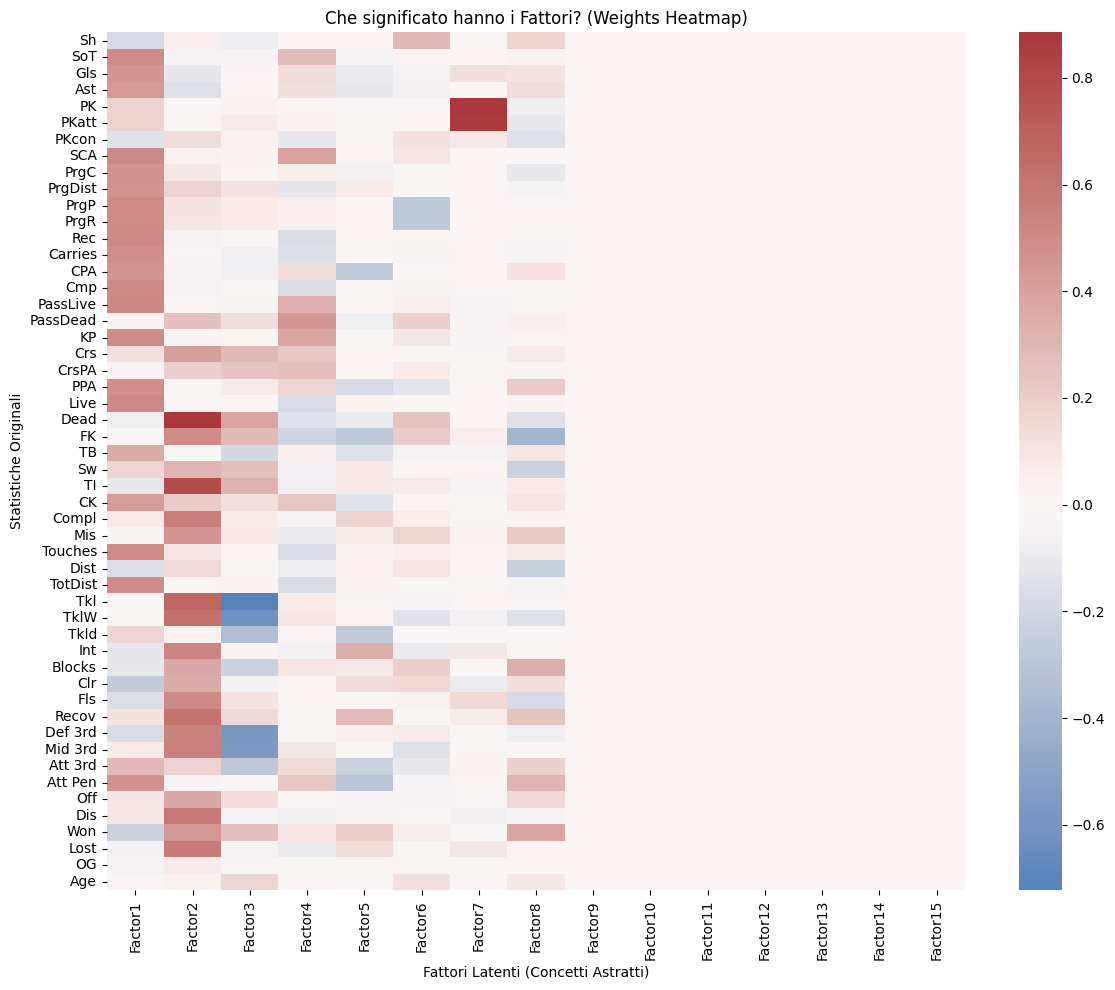

In [80]:
# HEATMAP DEI PESI

plt.figure(figsize=(12, 10))

# 1. Togliamo la colonna 'View' (che è testo)
data_to_plot = df_weights.drop('View', axis=1)

# 3. Disegniamo la heatmap
sns.heatmap(
    data_to_plot, 
    cmap="vlag",   # Blu = negativo, Rosso = positivo
    center=0, 
    annot=False,   # Metti True se vuoi vedere i numeri precisi
    yticklabels=True
)

plt.title("Che significato hanno i Fattori? (Weights Heatmap)")
plt.xlabel("Fattori Latenti (Concetti Astratti)")
plt.ylabel("Statistiche Originali")
# Aggiusta i margini per non tagliare le etichette
plt.tight_layout()
plt.show()